
## Analytics Specializations & Applications - Week 5

# Topic Modelling of Customers - Example Comparisons
----------

In this task we are going to quickly run through how to apply topic modelling to the data we look at in the Week 03 Exercises, to allow us to compare two very common topic modelling techniques, Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF), to a similar factorization technique that we already know - Principal Component Analysis.


## Scenario:
As before, let's use the setting of grocery wholesaler, whose customers are hotels, cafes, restaurants or food stores. so first, let's just rerun the initial code we had in the Week 3 exercises to load the wholesaler's data before we do some comparitive analysis of topic modelling techniques on it.


### Task 5a: Preparing the data
<span style="font-weight:bold; color:green;">&rarr; Run the following code to load in and cleanse our data:<span/>


In [1]:
import pandas
import numpy as np 

#-- load in the data
filename = "wholesale_customer_data.csv"
data = pandas.read_csv(filename)

#-- first remove the columns 'Region' and 'Channel'
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

#-- log the data to help normalize it
data = np.log(data)

#-- print out some summary statistics as per normal
data.describe()

,FRUIT_VEG,DAIRY,FROZEN,DELI,OTHER_GROCERY,HOUSEHOLD
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,7.301396,6.665133,8.441169,6.785972
std,1.480071,1.081365,1.284540,1.310832,1.116172,1.721020
min,1.098612,4.007333,3.218876,1.098612,1.098612,1.098612
25%,8.048059,7.334981,6.609678,6.011875,7.674616,5.548101
50%,9.048286,8.196159,7.330388,6.872645,8.467057,6.705018
75%,9.737064,8.880480,8.175896,7.506728,9.273854,8.274341
max,11.627601,11.205013,11.016479,10.777768,11.437986,10.617099


That should look familiar (remember we logged the data so it was more normally distributed, which is helpful when data is skewed). 

Now, also recall that whenever we do "factorization" to engineer some new data dervived features for our data (topic modelling essentially /is/ factorization) we are simply trying to take a matrix, and reduce its dimension. In our raw feature space we currently only have 6 dimensions - the produce categories. If we had more fine grained product categories we might have dozens of dimensions each with a spend in. If we were counting spend for each product itself, we would have thousands of dimensions.

But the size is irrelevent. To do a dimension reduction, we just need a matrix. We do here - a matrix where the rows are datapoints (in this case customers) and the columns are the values of that datapoint for each features (category spends). Let's just double check this:

In [2]:
data.head(5)

,FRUIT_VEG,DAIRY,FROZEN,DELI,OTHER_GROCERY,HOUSEHOLD
0,9.446913,9.175335,5.365976,7.198931,8.930759,7.891331
1,8.861775,9.191158,7.474205,7.482119,9.166179,8.099554
2,8.756682,9.083416,7.785305,8.967504,8.946896,8.165079
3,9.492884,7.086738,8.764678,7.488853,8.347827,6.228511
4,10.026369,8.596004,8.272571,8.553525,8.881558,7.482682


Looks good. Note that in this example we don't have a CUSTOMER_ID being tracked. Instead we're using the number of each row as an implicit "customer id". In other datasets you will have an ID - ensure that you hold it out so that ID isn't factorized itself! (and obviously you may need to keep track of the order of your matrix to rejoin that ID at the end to your results)

The other thing to note is that our analysis here is quite coarse grained (for example purposes), and the level of product categorization you pick is always up to you. If we were using individual products as our features we'd have a bigger matrix that would process more slowly, but the principal will be the same.

Consider also that while our matrix here considers customers spends, it could just as easily have rows representing documents, with the features represent the number of times each word appears in each. Whether we are doing customer analysis or text analytics, we always have the same type of matrix structure.


### Task 5b: Checking that you 'get' Factorization
It is important that you have understood that when we do compression we take our datapoints, and work out their coordinates in a smaller, compressed space. For factorization this mean we convert our matrix into two smaller matrices, where:

1. The first of these smaller matrices describes the new "axes" of our newly compressed space - and these are often called "topics", "themes" or "components" depending on the technique you use. Whatever their called they always just represent the axes of our new, compressed space. They can be interpreted.

2. The second of our new matrices contains each customer's (or documents) values (i.e. coordinates) in that smaller space. This shows how much each customer expressed the new topics/axes.

Now, I always consider the topics/components that are produced in the first as new "features", and values for them indicating how much that feature is expressed by any individual customer/document/datapoint. So with this in mind, let's do the "PCA" version of factorization on our data we did the following:

### Task 5c: PCA of Wholesale Customers
<span style="font-weight:bold; color:green;">&rarr; Run the following code again, and refresh your memory of the results.<span/>

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

#-- Generate a PCA factorization of your data
pca = PCA(n_components=3)
pca.fit(data)

#-- print out the extent to which each original category/feature contributes to 
#-- each of the 3 newly derived factors/topics
print(data.columns)
print(pca.components_)

Index(['FRUIT_VEG', 'DAIRY', 'FROZEN', 'DELI', 'OTHER_GROCERY', 'HOUSEHOLD'], dtype='object')
[[ 0.17371704 -0.394463    0.17219603 -0.1494356  -0.45436364 -0.74551495]
 [-0.68513571 -0.16239926 -0.487691   -0.50970874 -0.06937908 -0.04191162]
 [-0.67351166  0.03306794  0.28481122  0.64459672 -0.03218274 -0.21824404]]


We are looking at the **first** of the two smaller matrices that our PCA factorization produces (you might want to think of it as the "topic" description matrix) - the one that represents the new topics/components. Each row here is one of those factors (with each individual number showing how much each category contributed to that factor). 

Last time we did a visualization of this first smaller matrix, so let's do that again, except this time i'll include the graphing function for you to look at:

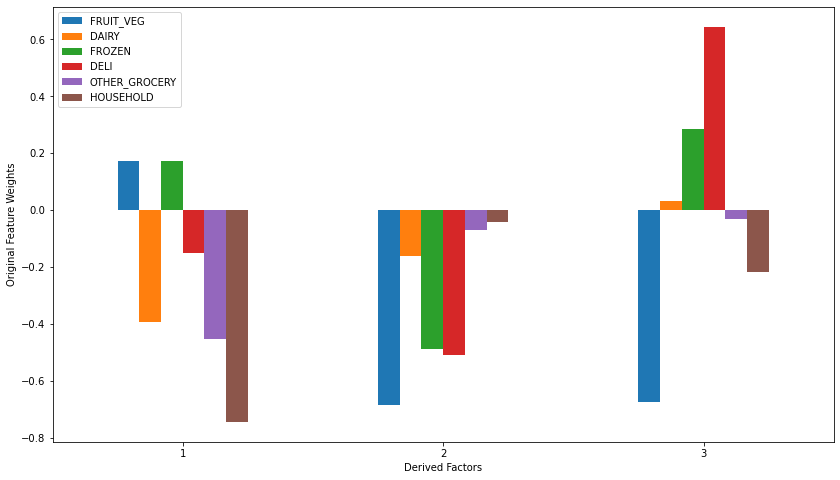

In [4]:
def display_factors(model, original_features):
   dimensions = range(1, len(model.components_) + 1)
   topics = pandas.DataFrame(model.components_, columns = original_features)
   fig, ax = plt.subplots(figsize = (14,8))
   topics.plot(ax = ax, kind = 'bar');
   ax.set_ylabel("Original Feature Weights")
   ax.set_xlabel("Derived Factors")
   ax.set_xticklabels(dimensions, rotation=0)

display_factors(pca, data.columns)

Each bar chart is one of our new factors/components/topics, and the bar heightss shows how much each of the original categories contributes to that new factor/component/topic. 

Now with PCA some of these contributions can be negative, which can make it hard to interpret. That's just the way PCA works, and If you don't care about interpretation, then this isn't an issue. But in business analytics we often *do*.

So to address this another factorization technique was created that forced the new factors to only have positive weightings for each of the original features (making it therefore easier to interpret). This technique was called Non-negative matrix factorization. Let's try it out...


### Task 5d: NMF of Wholesale Customers
<span style="font-weight:bold; color:green;">&rarr; Run the following code and compare your new NMF "topics" to your PCA "topics" <span/>

/Users/gavinshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/gavinshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


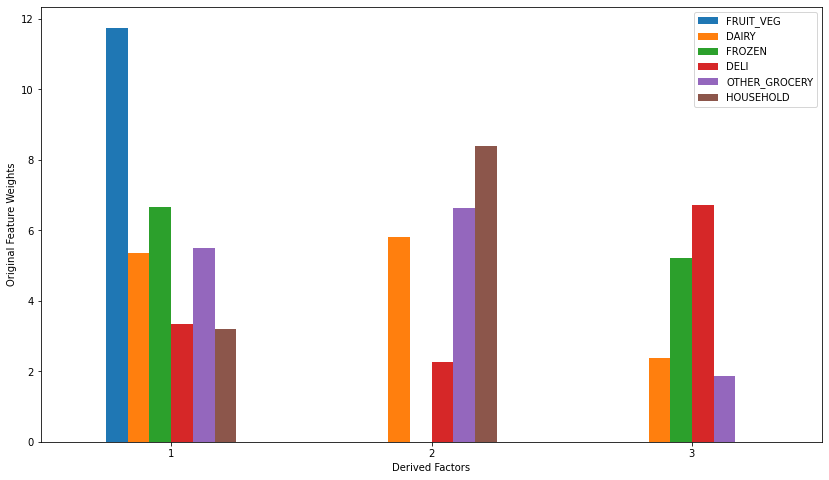

In [5]:
from sklearn.decomposition import NMF

#-- Generate a PCA factorization of your data
nmf = NMF(n_components=3, random_state=1)
nmf.fit(data)

#-- And visualize the results
nmf_results = display_factors(nmf, data.columns)

These are factors just like our principal components... but they've been forced to have positive weights for each of the original features. How would you interpret them? Well here's my attempt:

> **Topic 1: "Fresh Food Required"** - compared to other categories, fruit and veg gets bought twice as much.
>

> **Topic 2: "Milk and Practical Items"** - essentially a building block made out of "dairy", "other grocery" and "household". You may recall from the original Week 3 exercise that these items were all correlated, and that's come out here again - they reflect people who serve food, rather than just sell it.
>

> **Topic 3: "We do not cook"** - this topic heavily reflects a client who are not making their own meals from scracth, but buying frozen food, or pre-prepared items from the deli. 

These topics all make sense (more so than the PCA versions I'd say). Topics 1 and 2 are highly relevent to cafe's and restuarants - they prepare their own food every day so "fresh food is required" and they have to serve both tea and coffee, as well as clean up customer's mess so "Milk and Practical Items" is also key. Topic 3 however, is much more relevent to a food retailer. They don't prepare new food every day, so don't want fresh food that will go off, but rather frozen items - they "do not cook".


### Task 5e: LDA for Wholesale Customers

Finally, let's look at LDA, a rival technique to NMF that we know has been transferred across from text analytics. In text analytics your matrix has rows for each document, and each column represents the count of a particular word in that document. We consider instead documents to be customers purchasing histories and words to be the individual products they bought, with counts of each product analogising to counts of each word.

Let's try it on this data (note, you may get a depracation warning when you run the following code - ignore it!).

<span style="font-weight:bold; color:green;">&rarr; Run the following code and compare your new LDA "topics" to the previous options <span/>

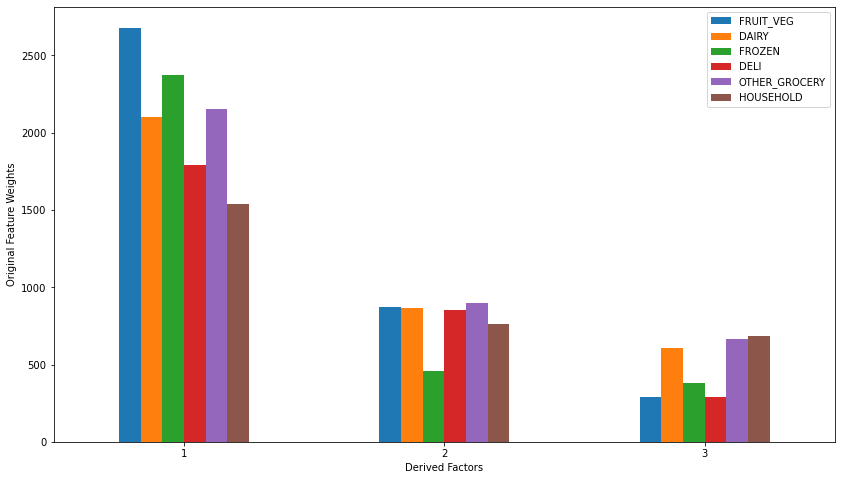

In [6]:
# TODO: Apply PCA by fitting the good data with only two dimensions
from sklearn.decomposition import LatentDirichletAllocation

#-- generate and visualize and LDA model.
lda = LatentDirichletAllocation(n_components=3, random_state=0)
lda.fit(data)
lda_results = display_factors(lda, data.columns)

I noted two things from my results:
1. Again our first factor is weighted toward fruit and veg, and the last reflects our now recognizable correlation between dairy, other_grocery, and practical items. But its much harder to see that distinction as clearly here.
2. It took longer to process the results.

So in this case, I would actually prefer to use my NMF factors - they are easier to interpret than PCA (not being negative) and LDA (being more distinctive) and they ran quickly. These NMF factors would become my new features, and each customer's values for them may be even fed forward into any clustering algorithm if I chose to follow such a path.

Now, sometimes I will prefer my LDA components, and sometimes (although less often!) I will prefer my PCA ones. Some times I won't just use my eyes to select, and actually check which produce the least errors if I 'reconstruct' my original data (by multiplying my two smaller matrices together). Perhaps if I'd applied tfidf to my data I'd have got better results - ultimately as long as you justify your choices, picking a topic modelling technique is subjective. In general I tend to prefer NMF for consumer data however.


### Task 5f: Listing the feature weightings in a topic to help interpretation
If we'd had not 6 original categories, but dozens, or even thousands (if we'd been looking at the spend of individual products) we would not have been able to look at bar charts of the results, and interpretation would have been trickier. In such cases, where we have lots of original features, we can order them in order of importances and interpret the top few of them to understand what the topic "means". To do so I would use code something like this:


In [7]:
for t, topic in enumerate(nmf.components_):
    print("\nTOPIC", t)
    print("----------")
    
    #-- attach the feature name to each topic weighting
    weightings = list(zip(topic, data.columns))
 
    #-- sort the weightings into an order
    ordered_indeces = topic.argsort()
    
    #-- make the order highest first
    reversed_indeces = ordered_indeces[::-1]
    
    #-- reduce it down to only the top 4 items
    top_3_indeces = reversed_indeces[:3]
    
    #-- print the results out to screen
    for i in top_3_indeces:
        print("{:.2f} {}".format(weightings[i][0], weightings[i][1]))
    


TOPIC 0
----------
11.75 FRUIT_VEG
6.66 FROZEN
5.49 OTHER_GROCERY

TOPIC 1
----------
8.39 HOUSEHOLD
6.64 OTHER_GROCERY
5.81 DAIRY

TOPIC 2
----------
6.70 DELI
5.22 FROZEN
2.39 DAIRY


### Task 5g: Using topics as new features
Last but not least we can cast all of our customers in terms of our new topics:


In [8]:
feature_names = ["FRESH FOOD", "PRACTICAL ITEMS", "WE DON'T COOK"]
new_features = nmf.transform(data)

print(feature_names)
print(new_features)

['FRESH FOOD', 'PRACTICAL ITEMS', "WE DON'T COOK"]
[[0.75880092 0.68278504 0.31558986]
 [0.74755978 0.66705203 0.49915451]
 [0.71661776 0.65319056 0.67089151]
 ...
 [0.78028195 0.84035425 0.33300901]
 [0.75800565 0.36444147 0.54352957]
 [0.67088936 0.55834796 0.04527106]]


Great. You'll note that **.fit()** created the first of our smaller matrices (the topic matrix) and now **.transform()** has given us access to the second one (the customer's new coordinates). And this is the point we would now rejoin our customers IDs (they will still be in the same order as our original data!). 

We could then even cluster in this new space. Not so useful in this example as we only had 6 categories to start with, but if we'd started with doznes or thousands of product categories/items, now we'd be down to a much easier space to cluster/segment in.

In [15]:
a = pandas.DataFrame(new_features, columns=feature_names)
a

,FRESH FOOD,PRACTICAL ITEMS,WE DON'T COOK
0,0.758801,0.682785,0.315590
1,0.747560,0.667052,0.499155
2,0.716618,0.653191,0.670892
3,0.809015,0.385742,0.584705
4,0.828407,0.532361,0.603601
...,...,...,...
435,0.905243,0.397785,0.645395
436,0.877120,0.184150,0.586329
437,0.780282,0.840354,0.333009
438,0.758006,0.364441,0.543530
